In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import os
import numpy as np
import ast

def get_files_by_keywords(directory, keywords):
    """
    遍历指定文件夹，根据关键字数组提取文件。
    """
    # 存储符合条件的文件名
    matched_files = []
    # 遍历目录中的所有文件
    for filename in os.listdir(directory):
        # 检查文件名是否包含所有关键字
        if all(keyword in filename for keyword in keywords):
            matched_files.append(filename)
    return matched_files

###### 修改这里 ########
ap_count="2ap"
project_root="/Users/daylight/Desktop/macos/1Code/Competition/2024ShuMo"
data_dir = project_root + "/data/B"
training_data_names = get_files_by_keywords(data_dir, ["training", ap_count,"csv"])
training_data_all_path = project_root + f"/data/processed/training_data_{ap_count}.csv"
os.makedirs(os.path.dirname(training_data_all_path), exist_ok=True)
training_data_names = sorted(training_data_names)

#### 读取所有训练数据 #####
training_data_all = pd.DataFrame()
# 初始化一个变量来追踪全局的最大 test_id
current_max_test_id = 0
file_split_id = []  # 记录分隔文件的id位置
for file in training_data_names:
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path)
    # 获取当前合并DataFrame中的最大test_id，如果为空则设置为0
    if not training_data_all.empty:
        max_test_id = training_data_all["test_id"].max()
    else:
        max_test_id = 0
    # 调整新df的test_id，保证test_id连续递增
    df["test_id"] = df["test_id"] + max_test_id
    # 将当前DataFrame追加到总的training_data_all中
    training_data_all = pd.concat([training_data_all, df], ignore_index=True)
    file_split_id.append(training_data_all["test_id"].max())
# training_data_all.to_csv(training_data_all_path, index=False)
# ############

In [7]:
######## 按ap_id分组 ########
grouped_data = training_data_all.groupby("ap_id")
data_split_by_ap_name = {}
for ap_name, group in grouped_data:
    data_split_by_ap_name[f"{ap_name}"] = group
    # if ap_name == "ap_0":
    #     data_raw_ap_0 = group
    # elif ap_name == "ap_1":
    #     data_raw_ap_1 = group
    # elif ap_name == "ap_2":
    #     data_raw_ap_2 = group
    # else:
    #     pass

# 初步绘图

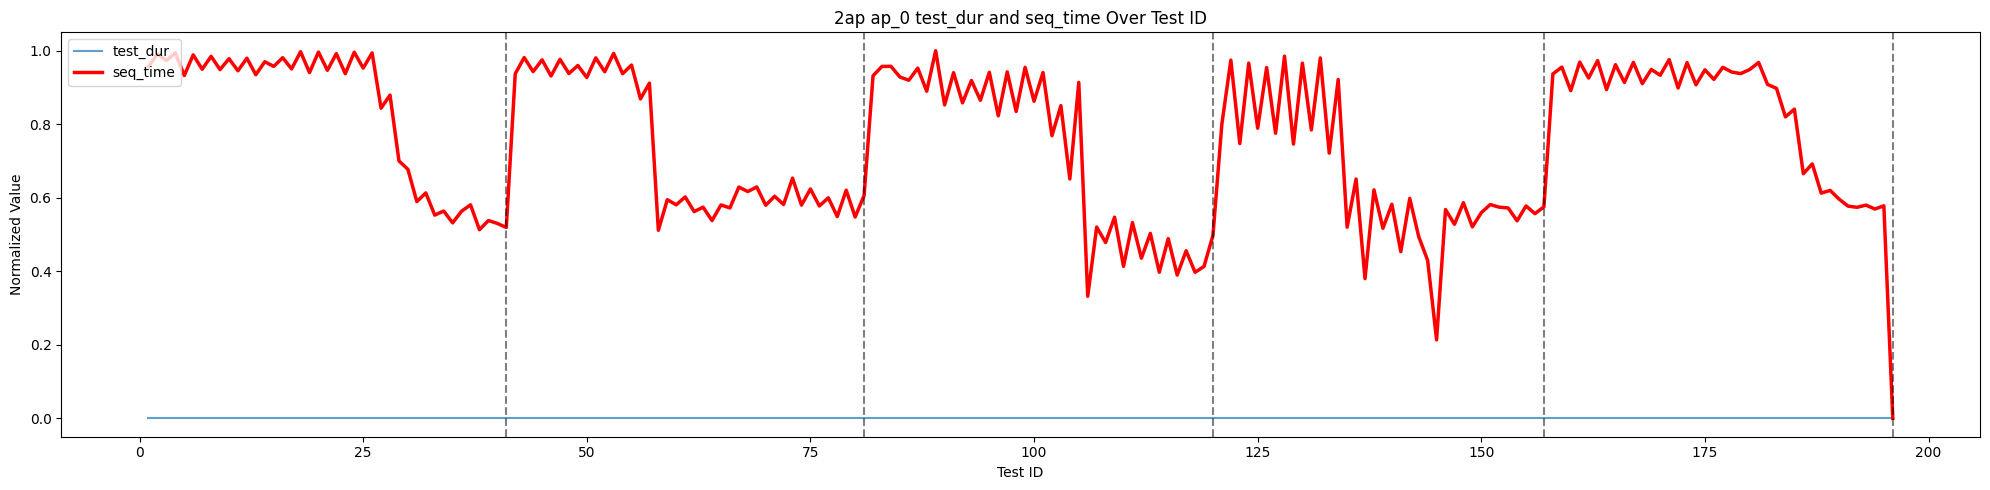

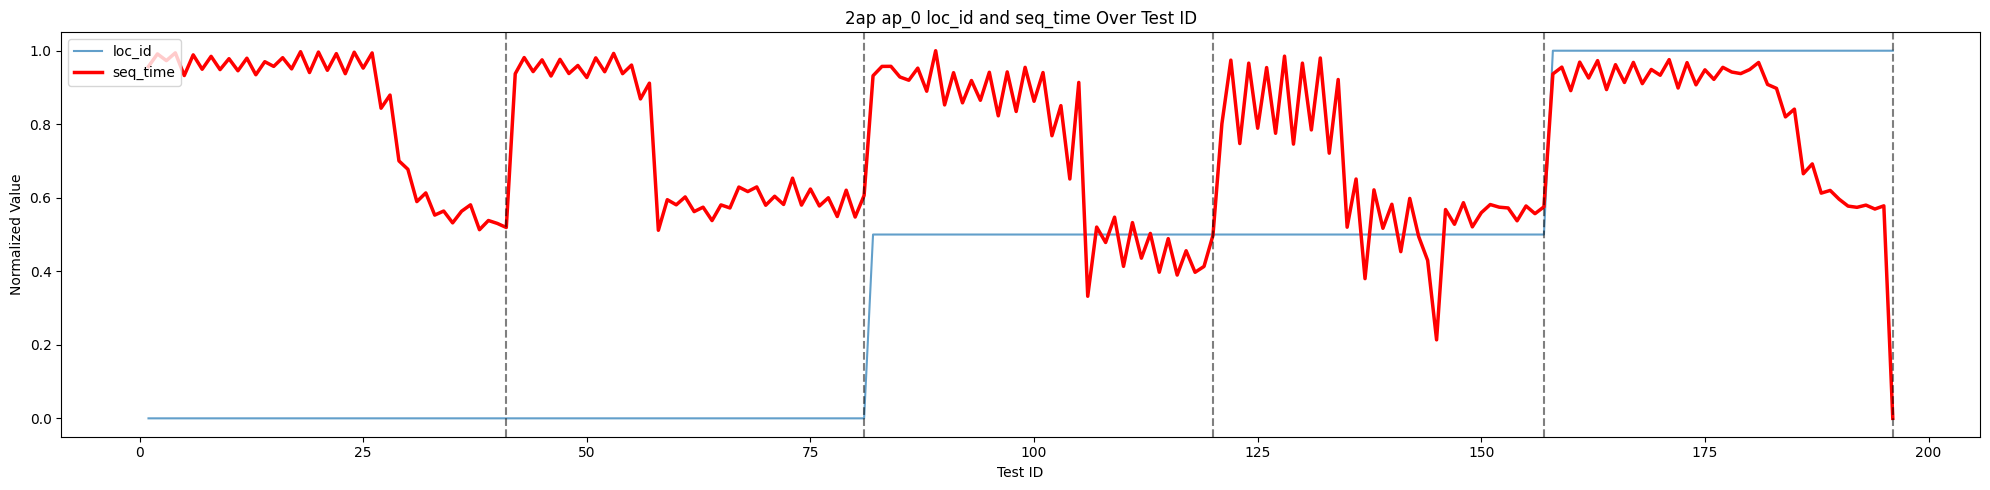

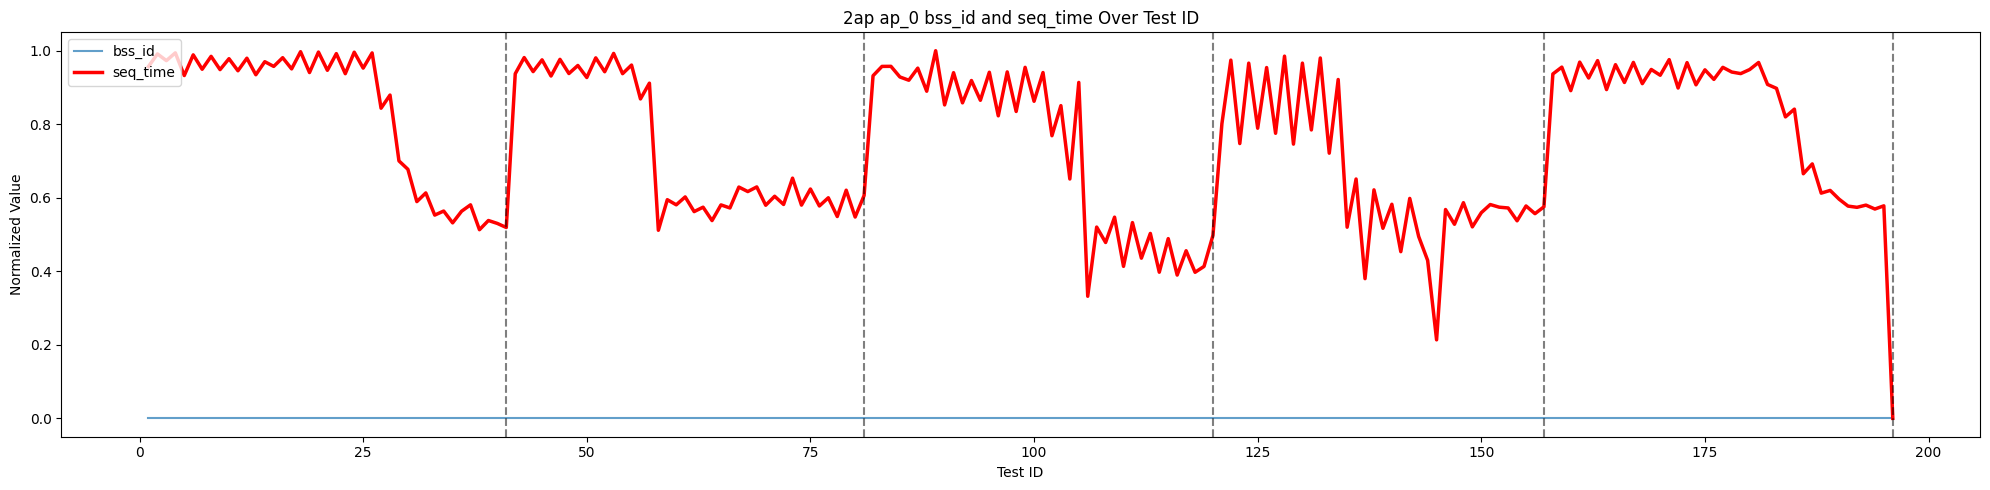

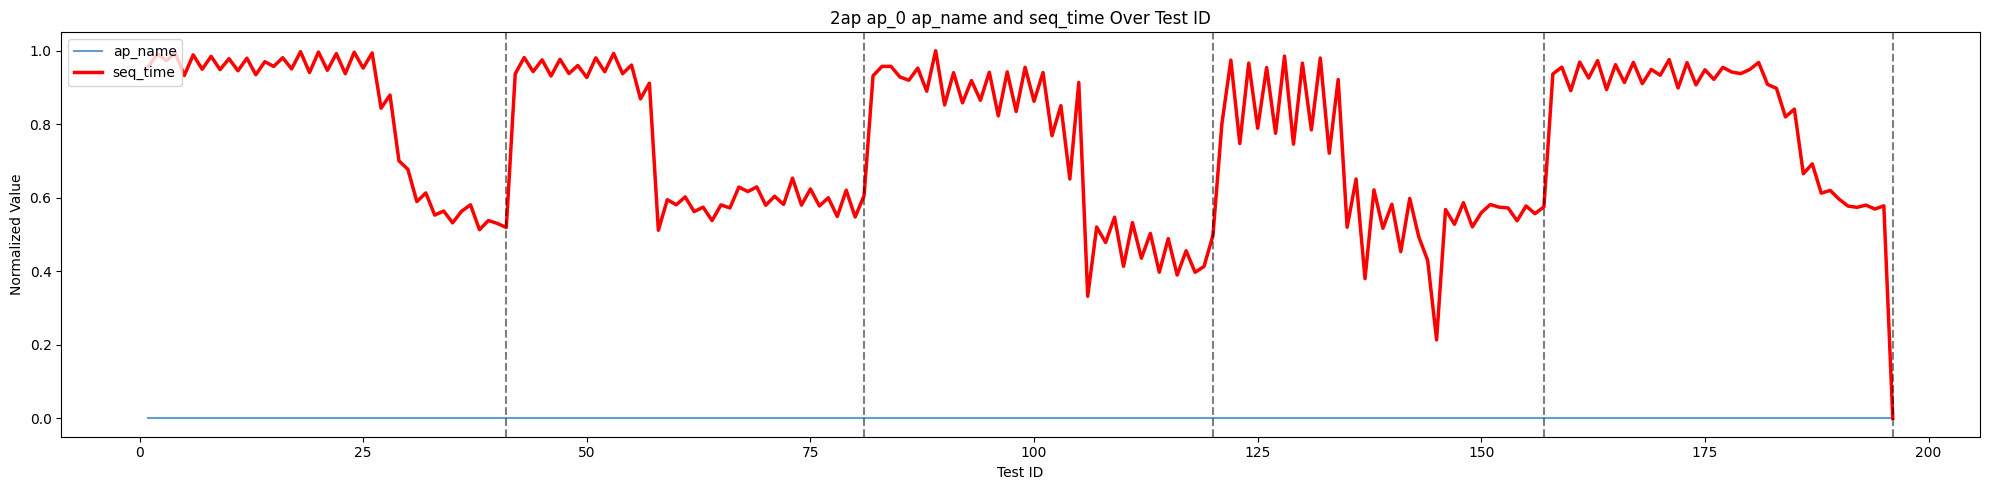

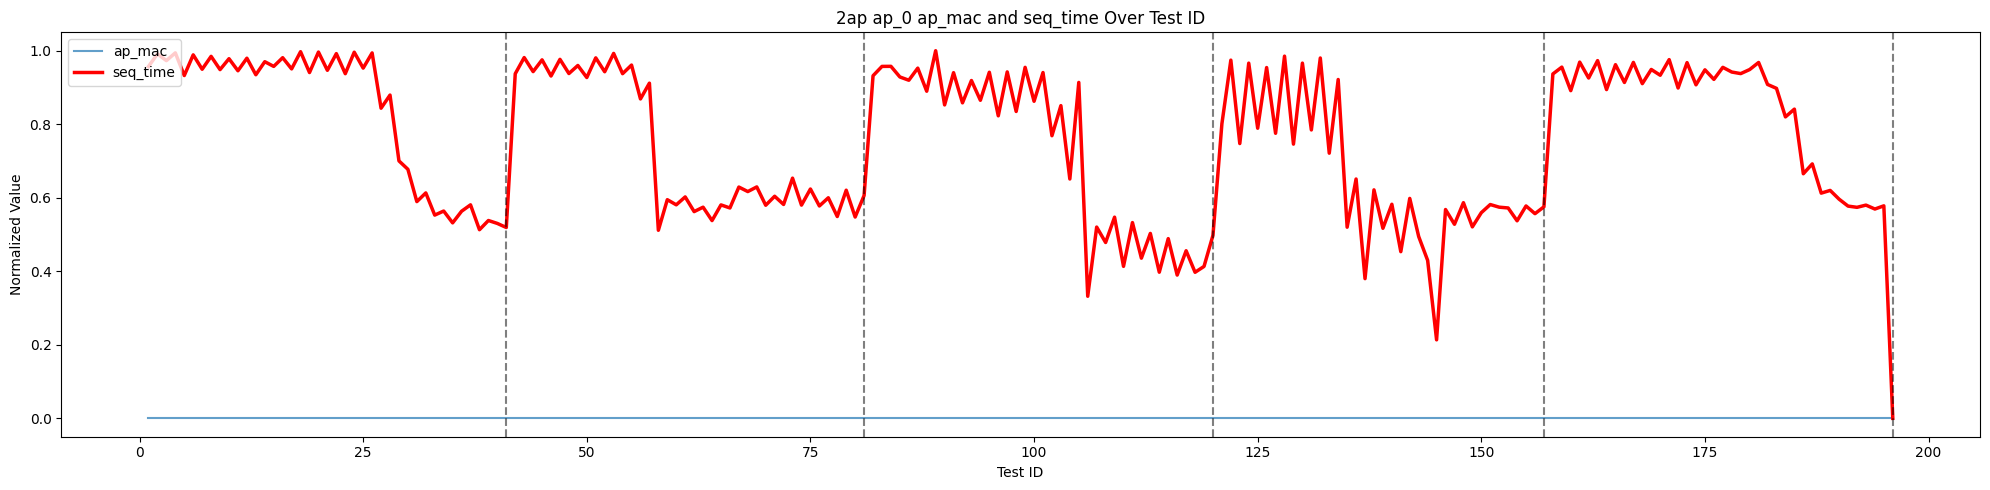

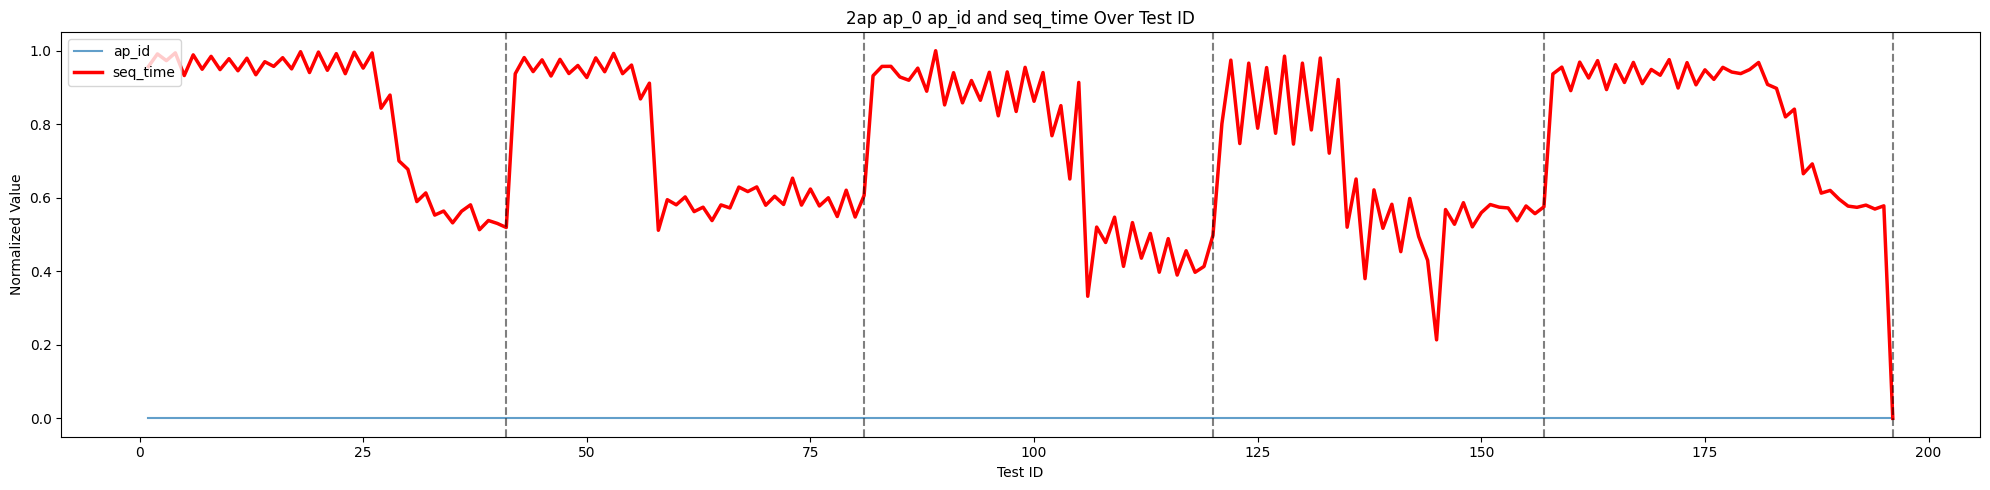

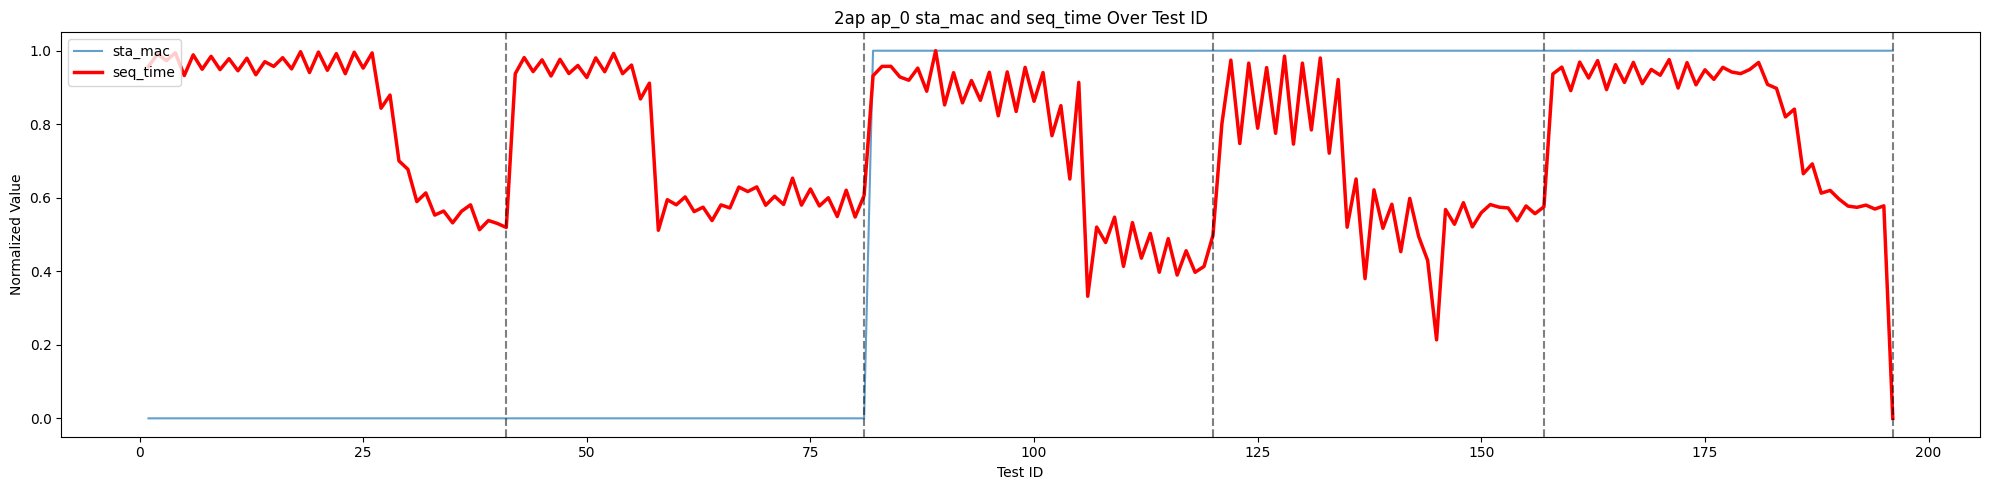

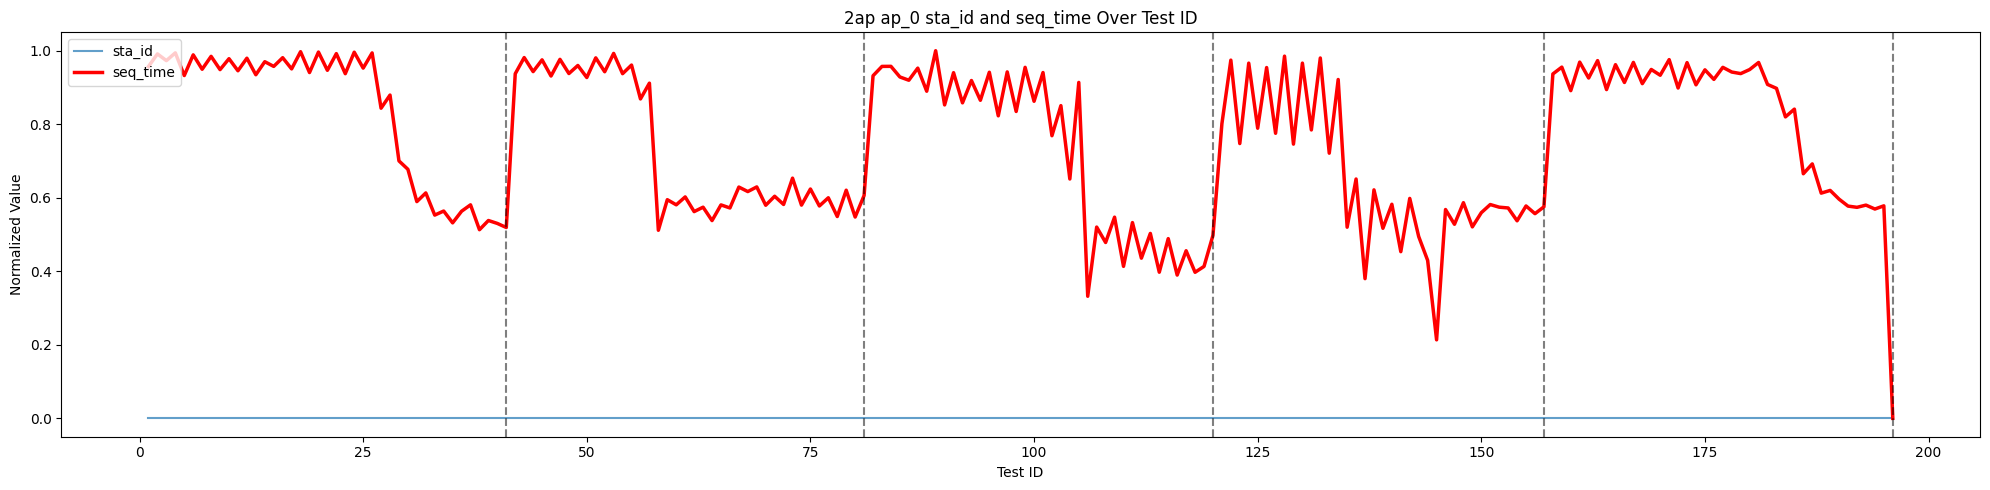

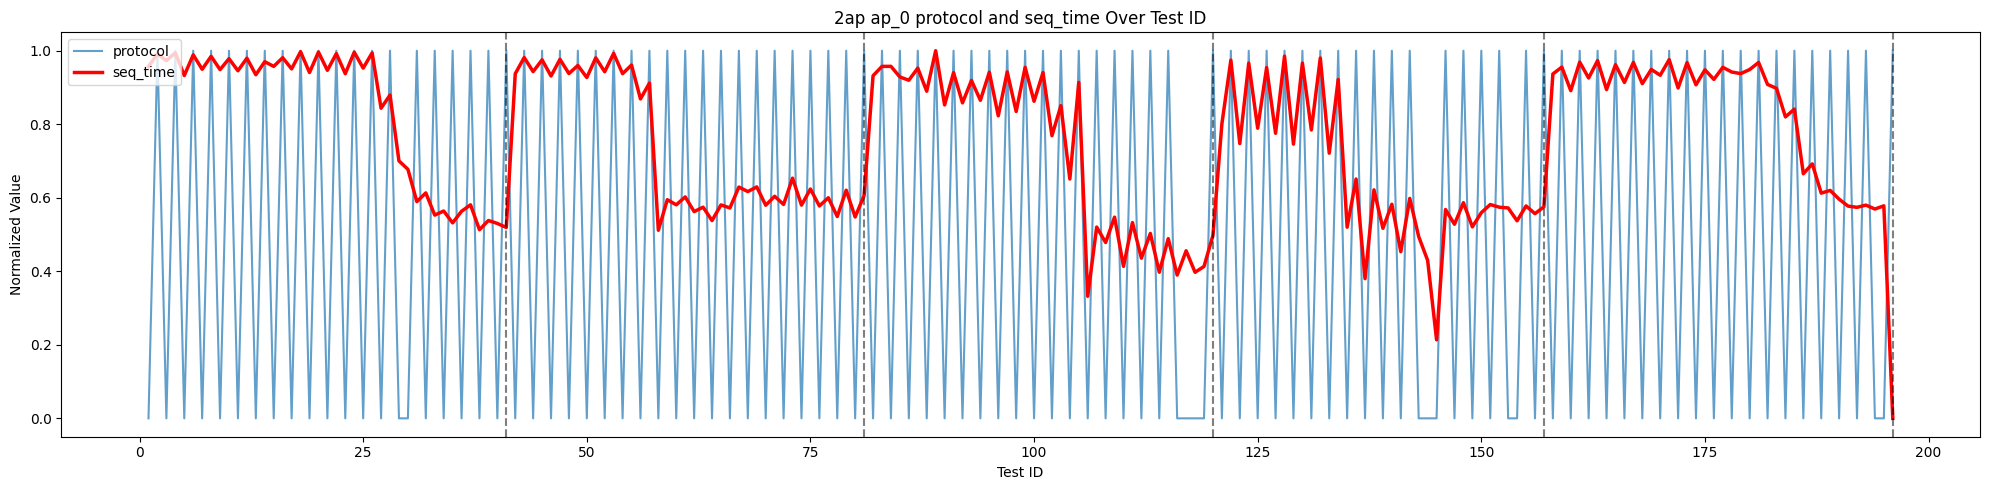

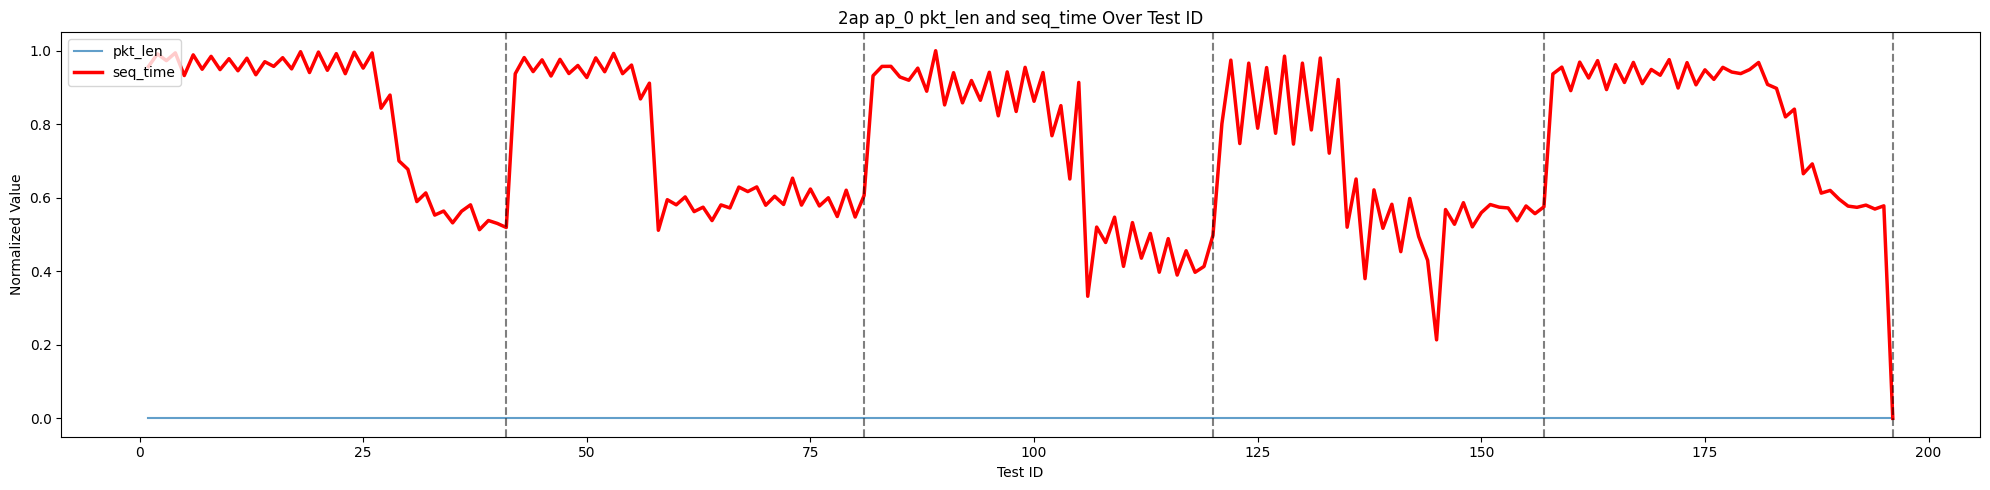

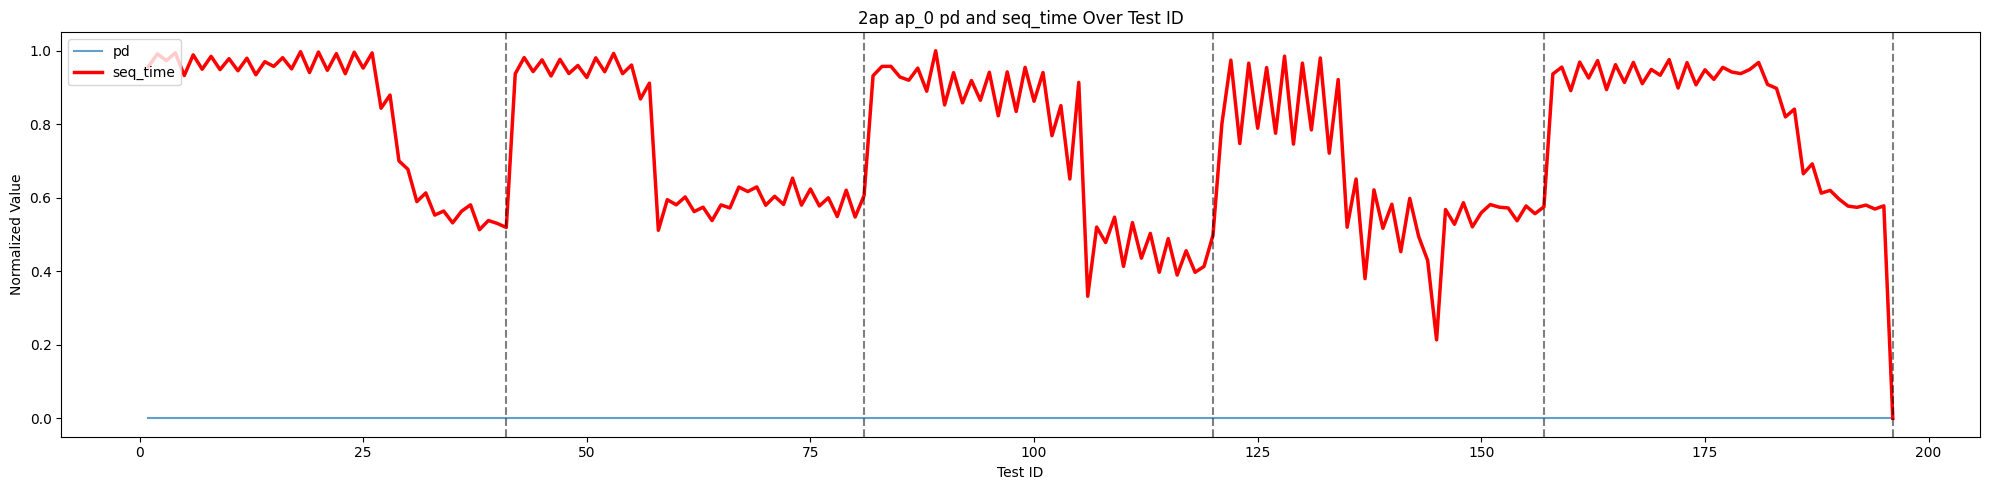

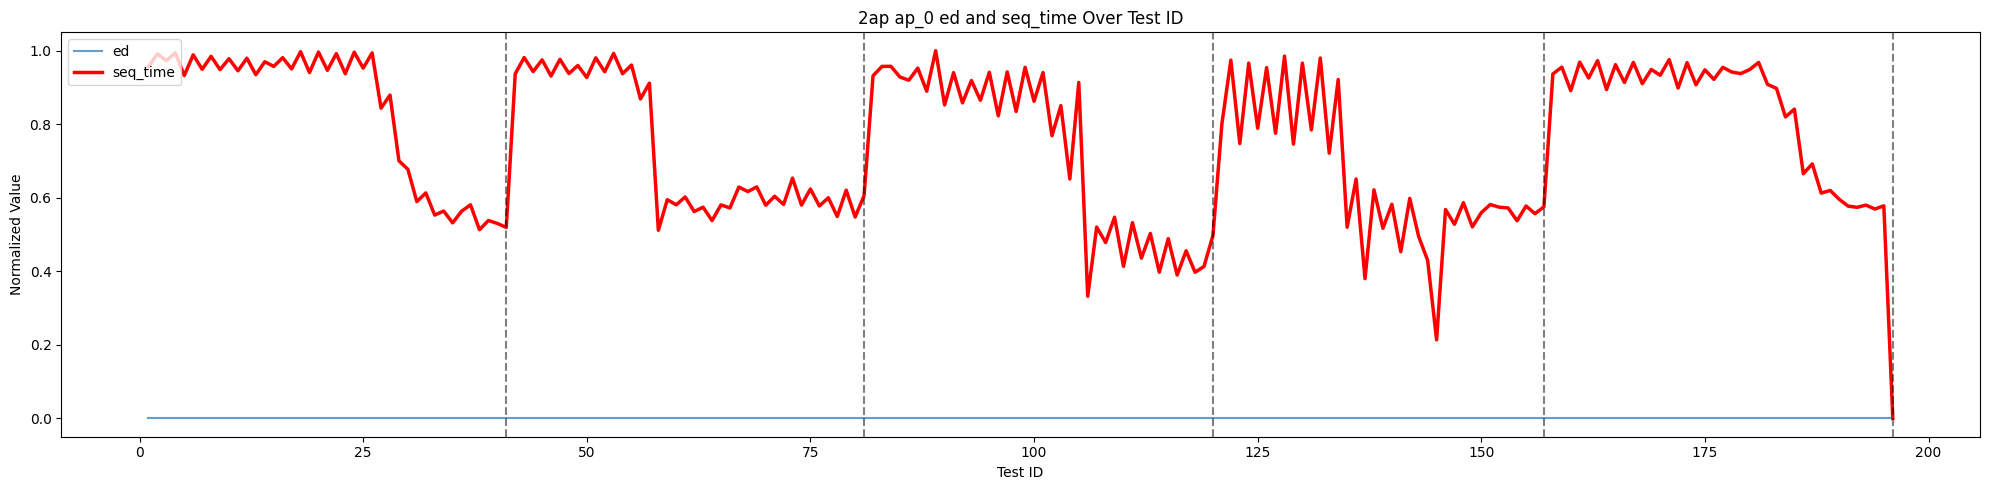

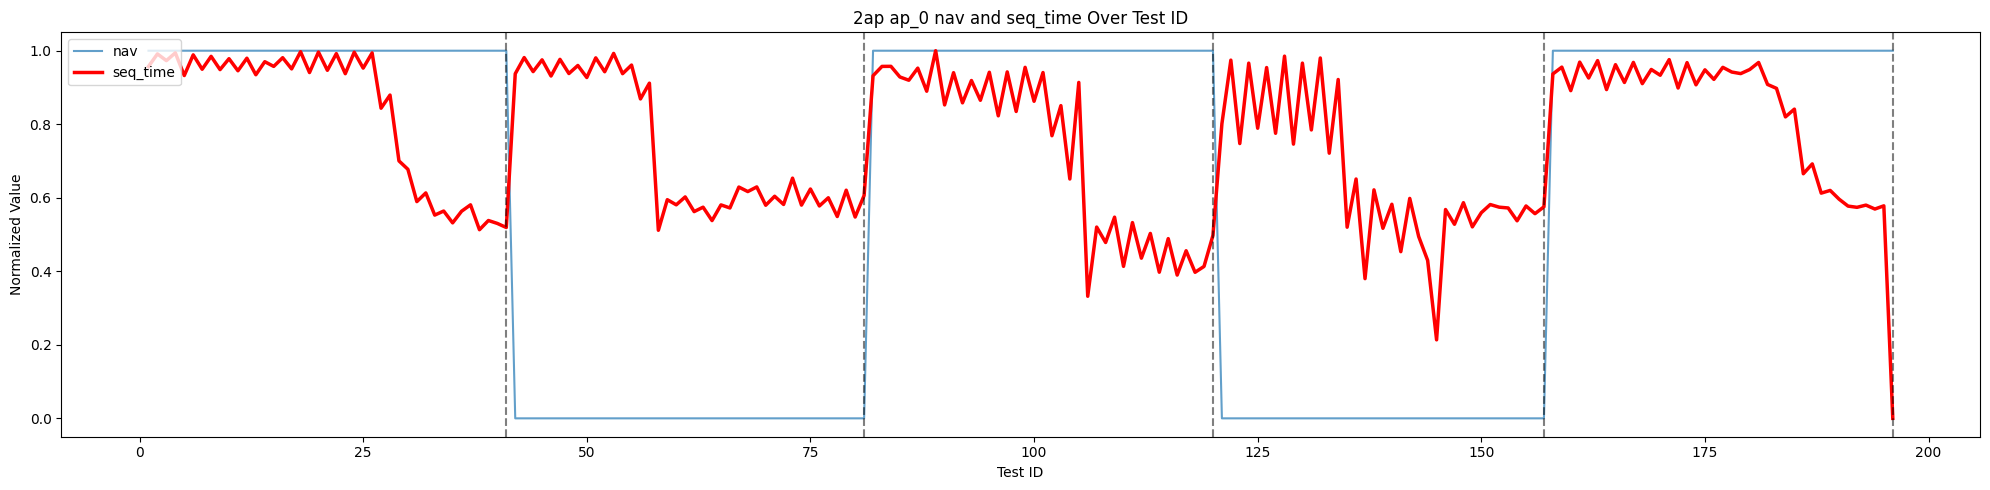

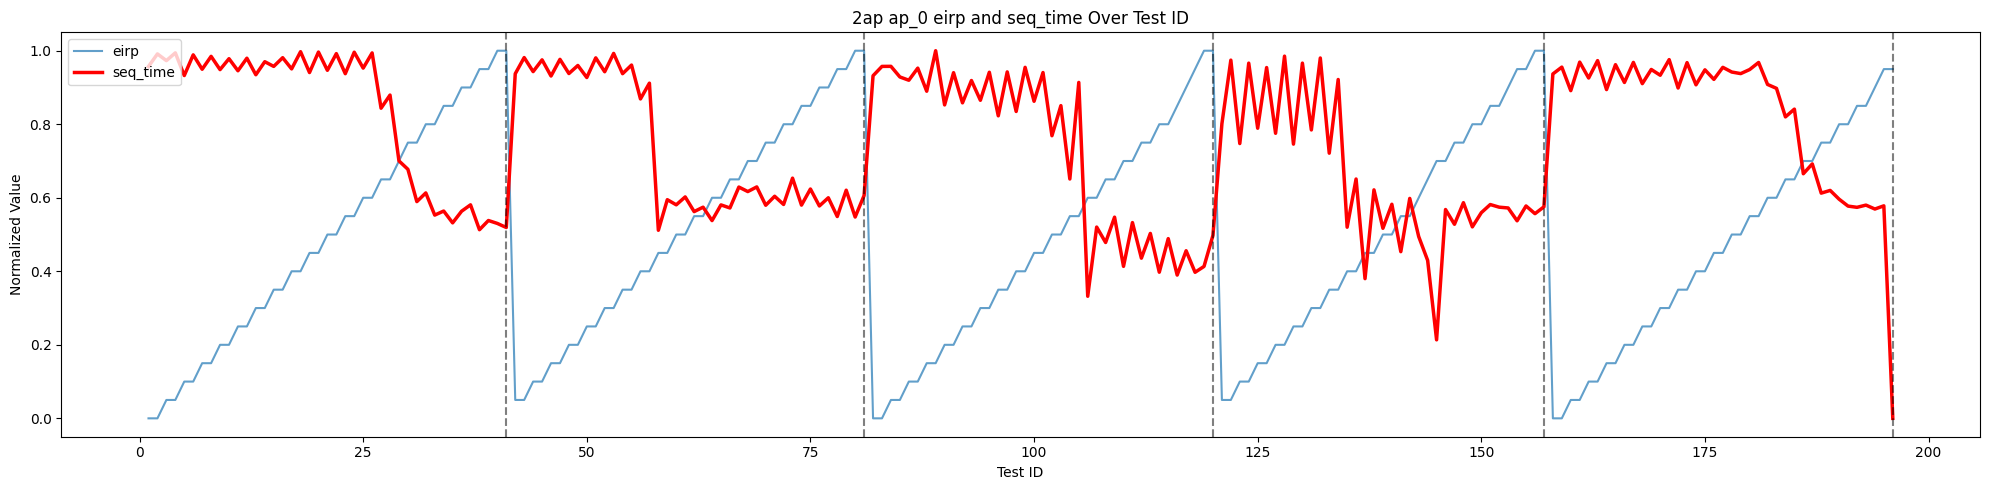

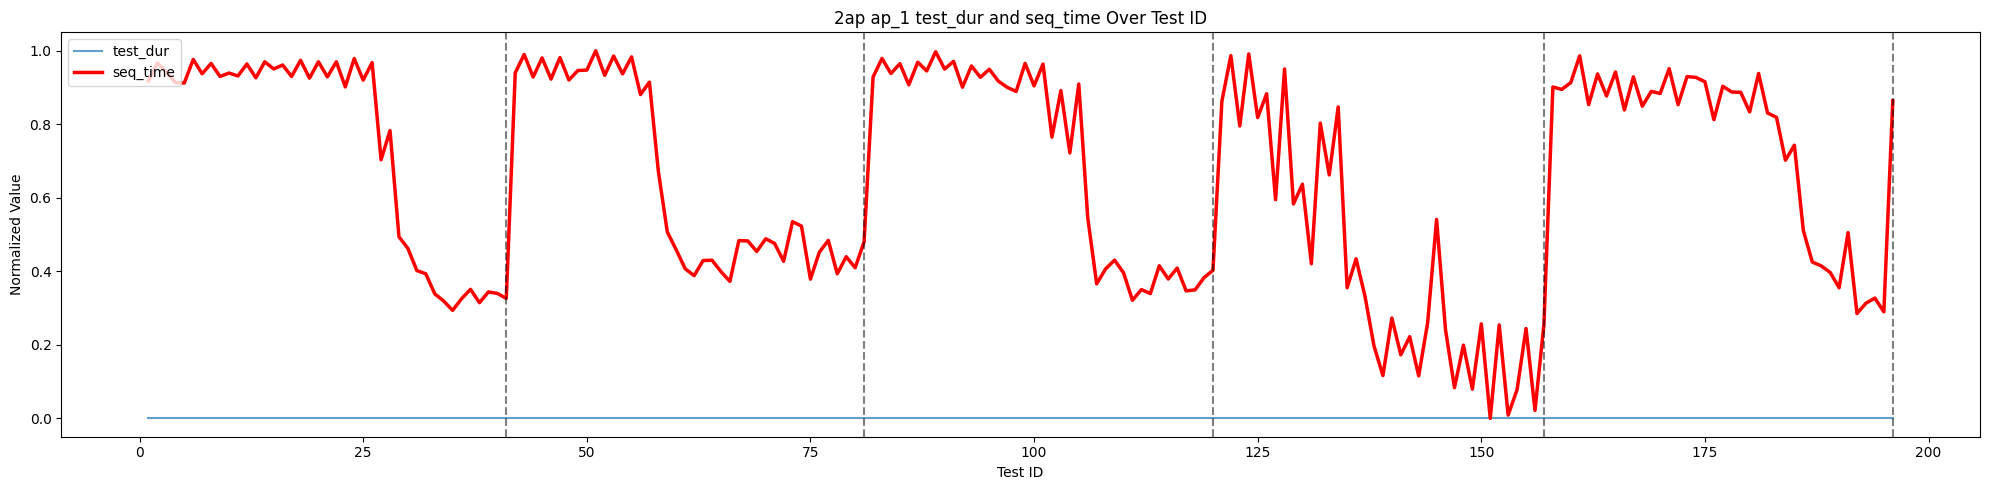

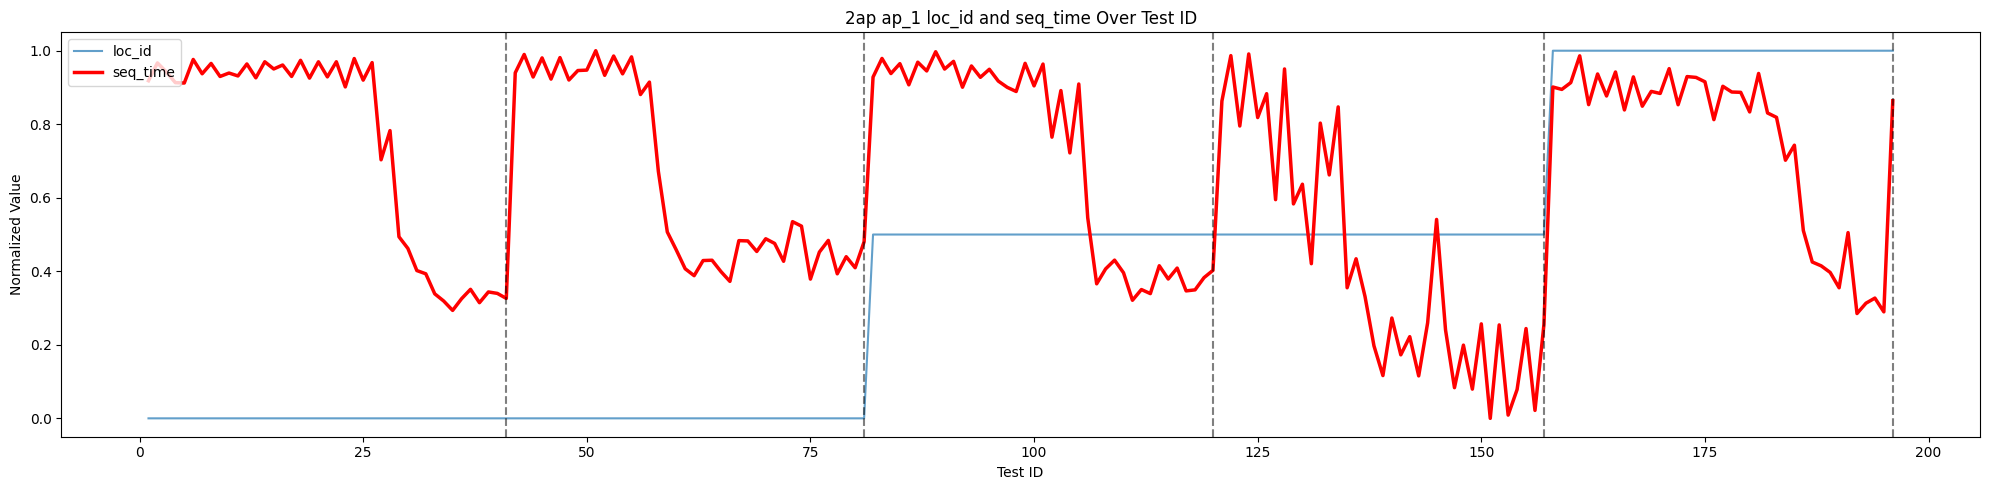

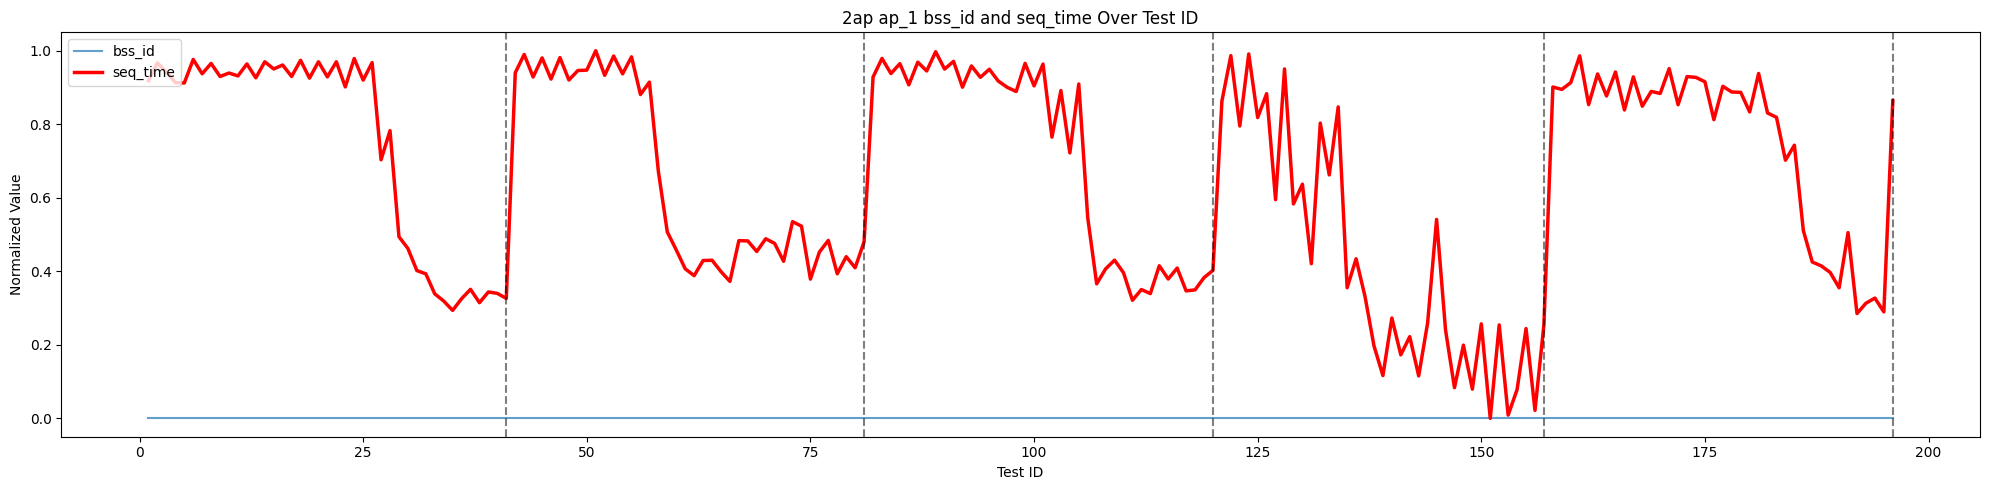

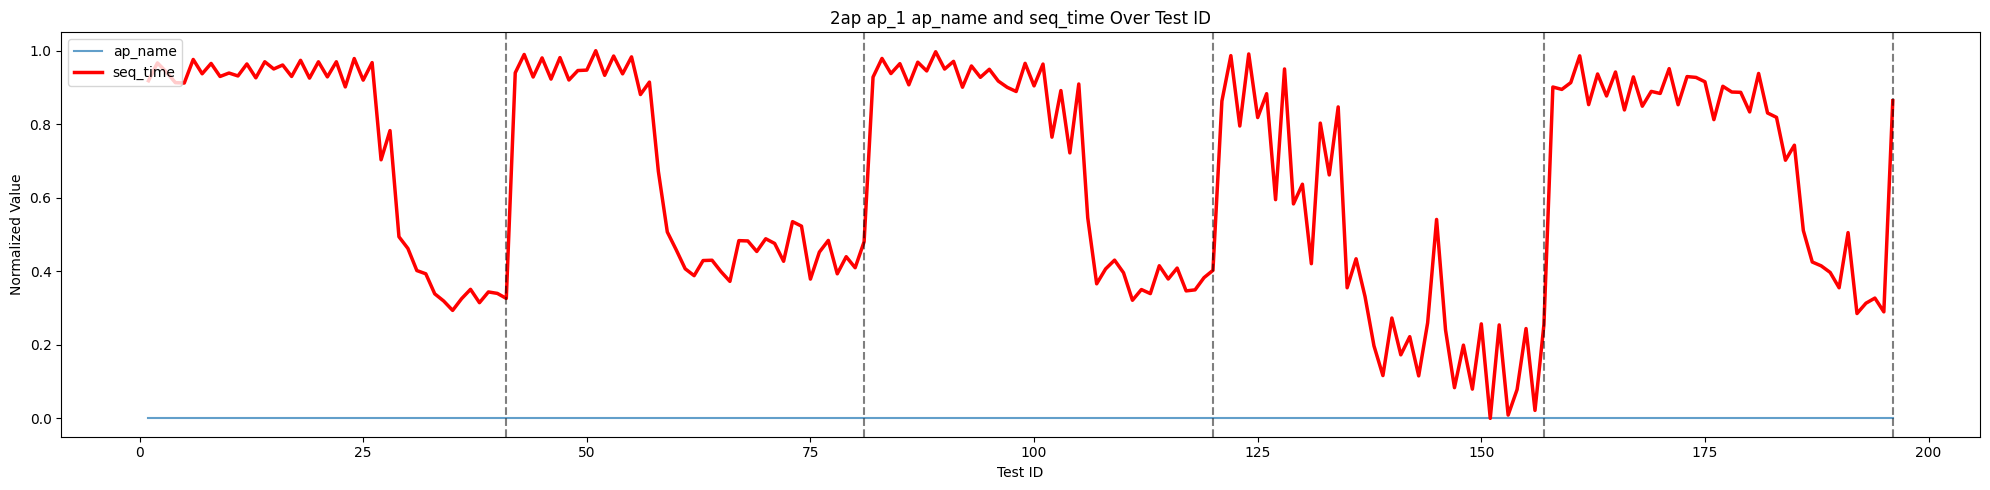

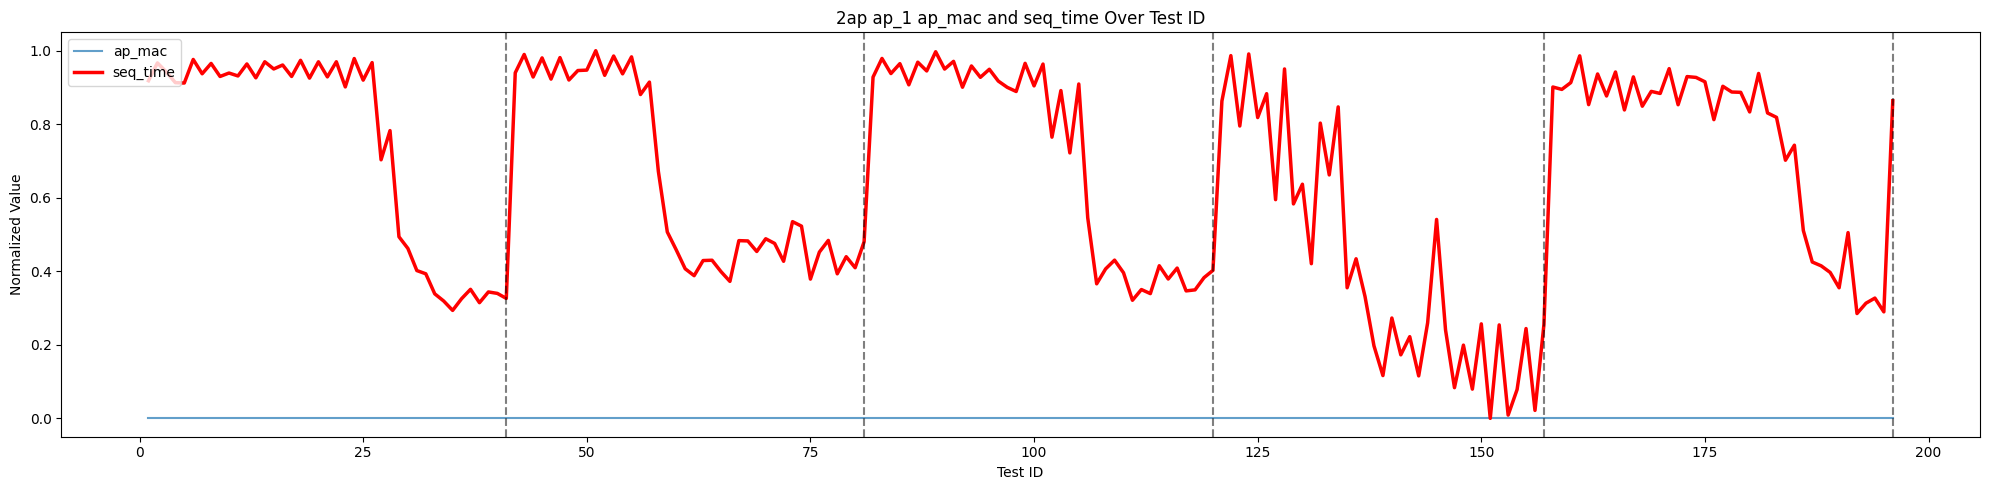

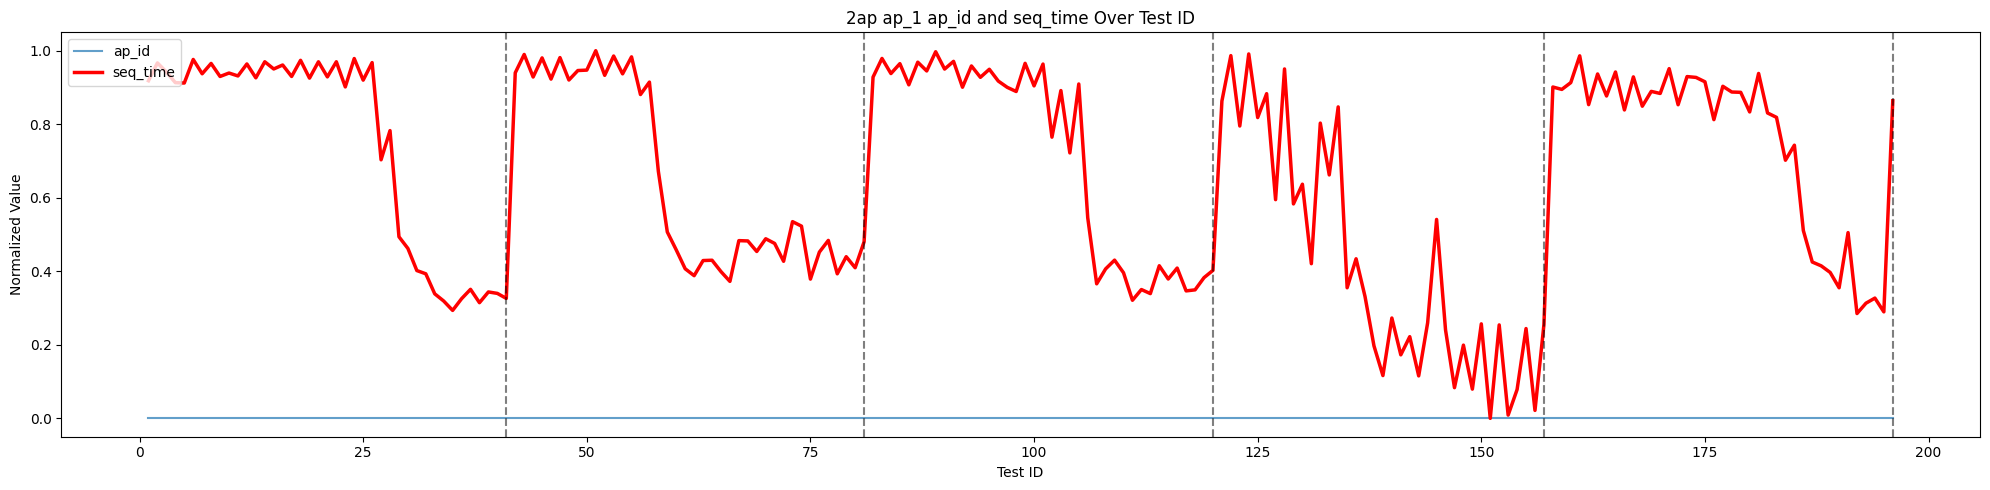

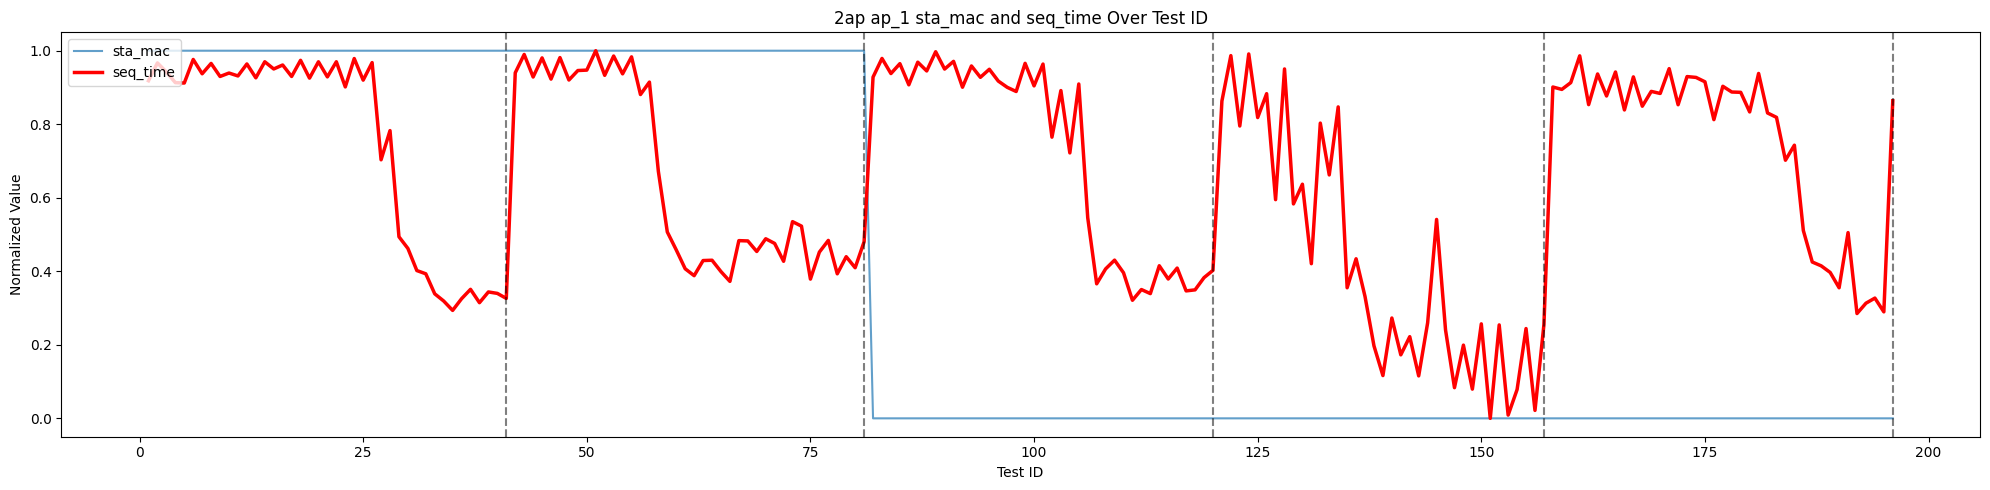

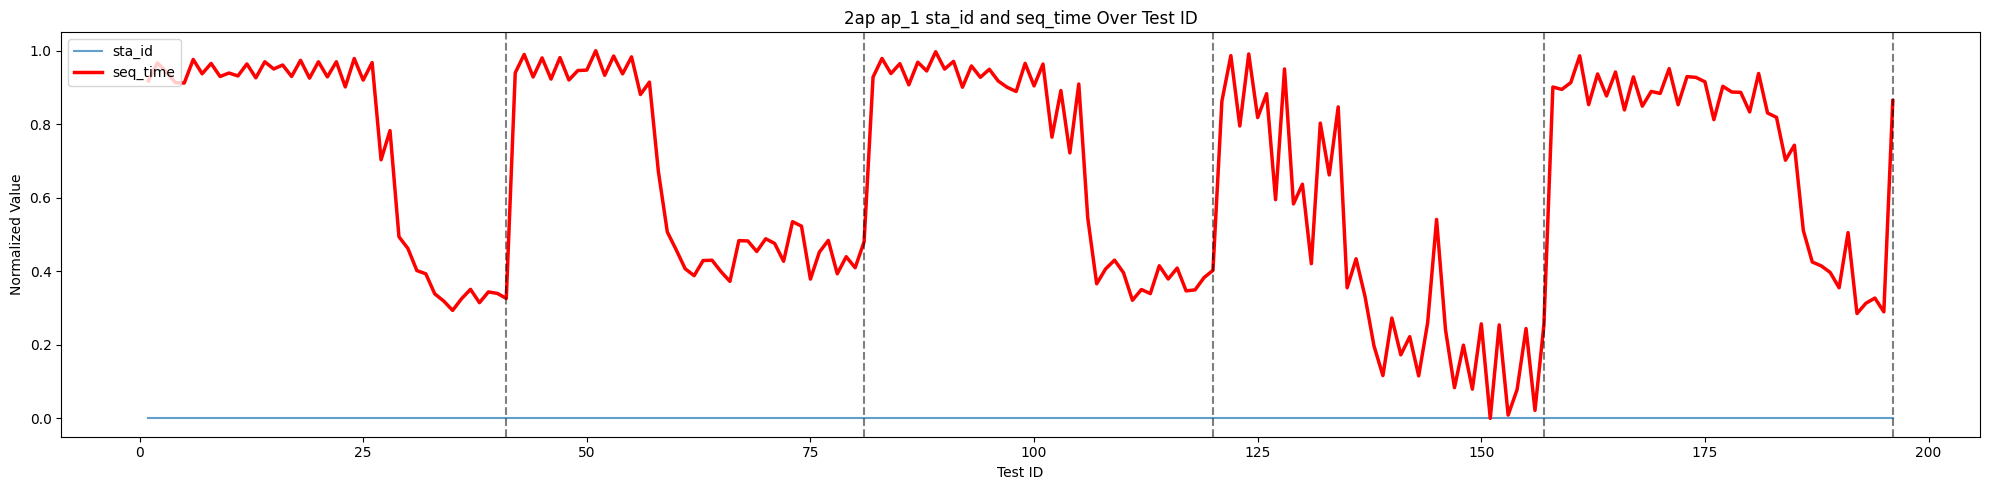

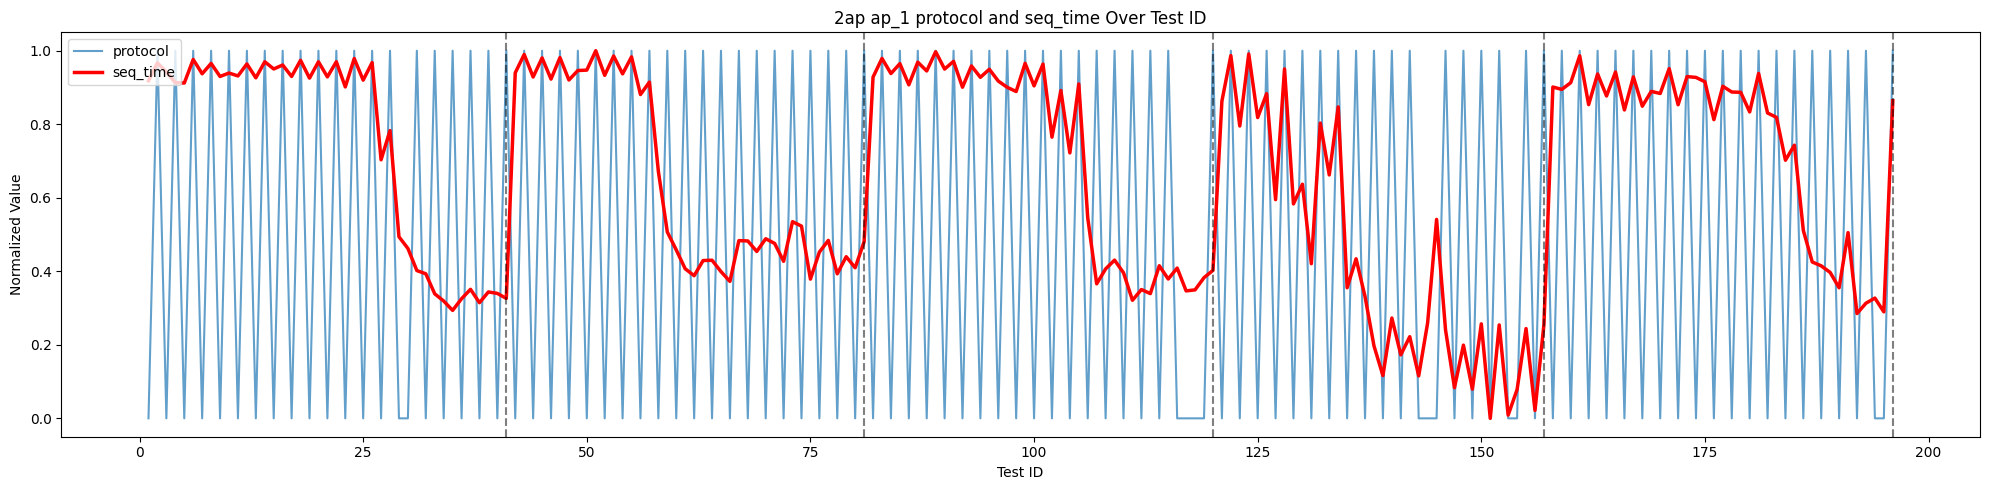

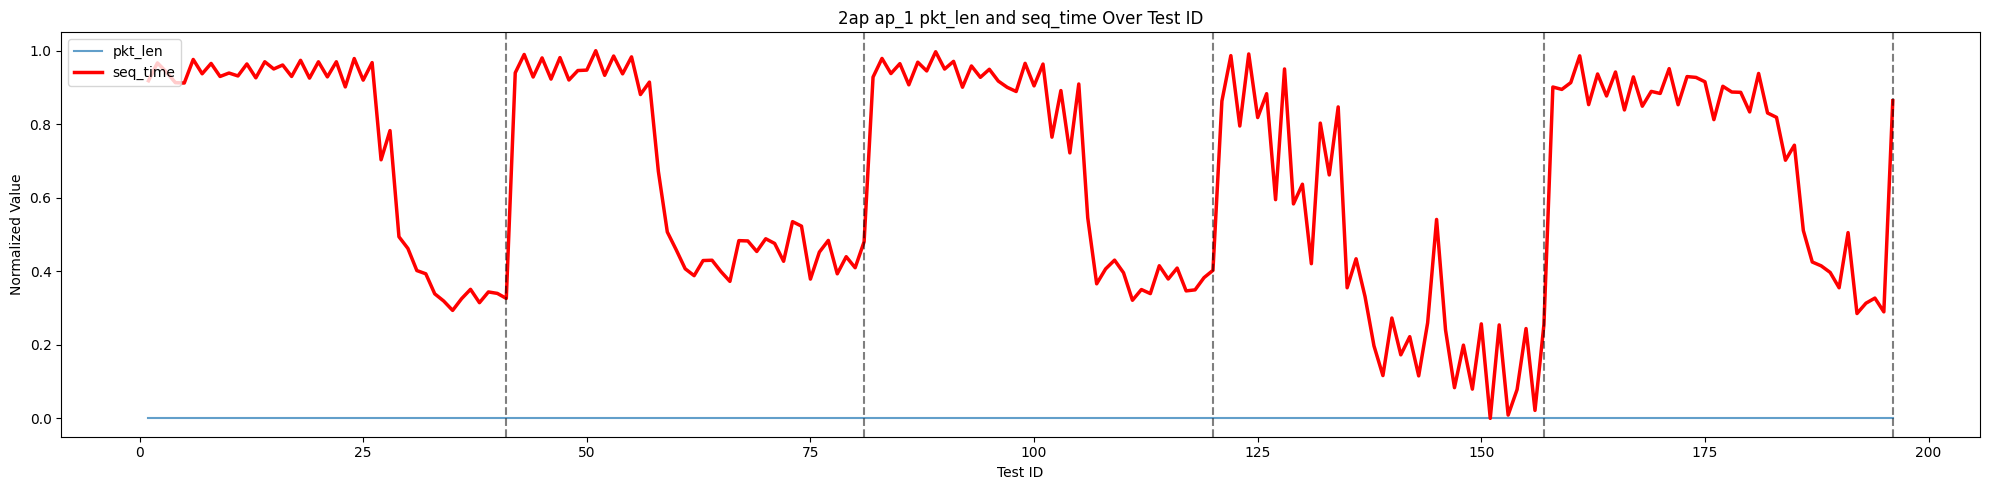

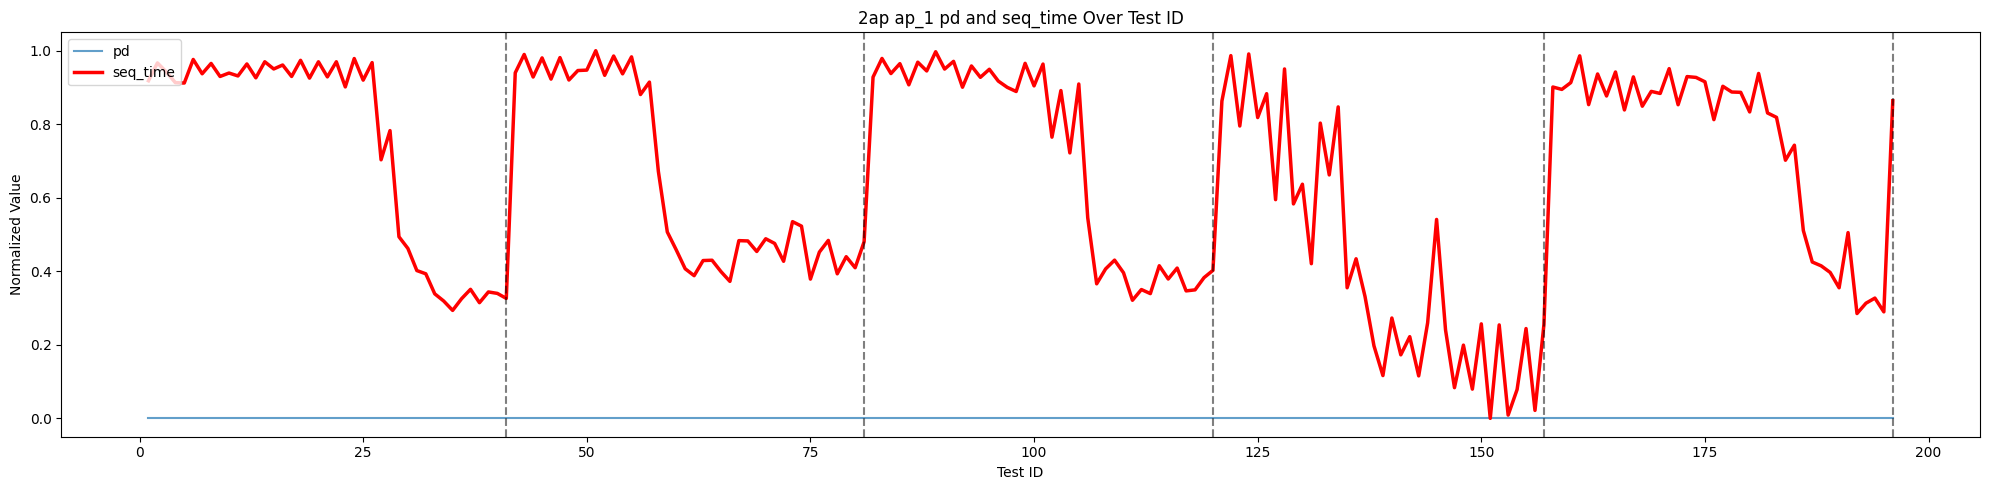

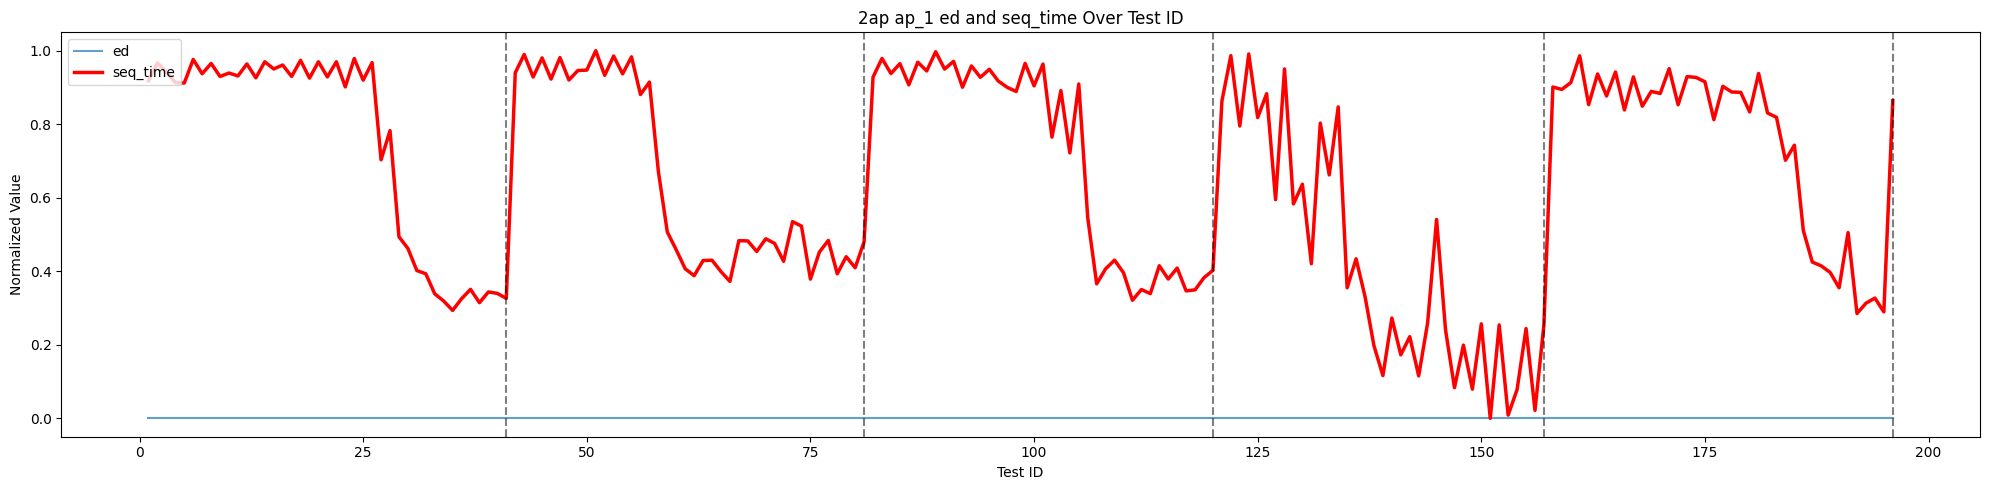

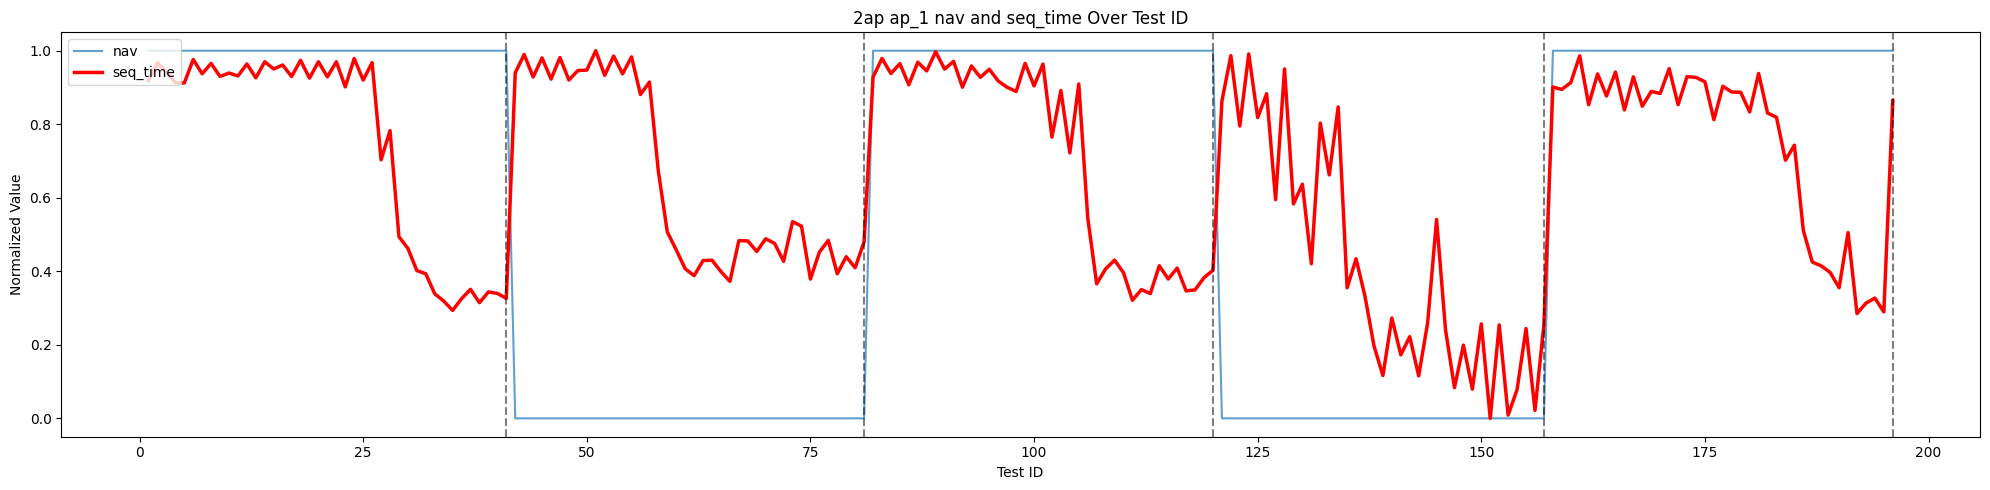

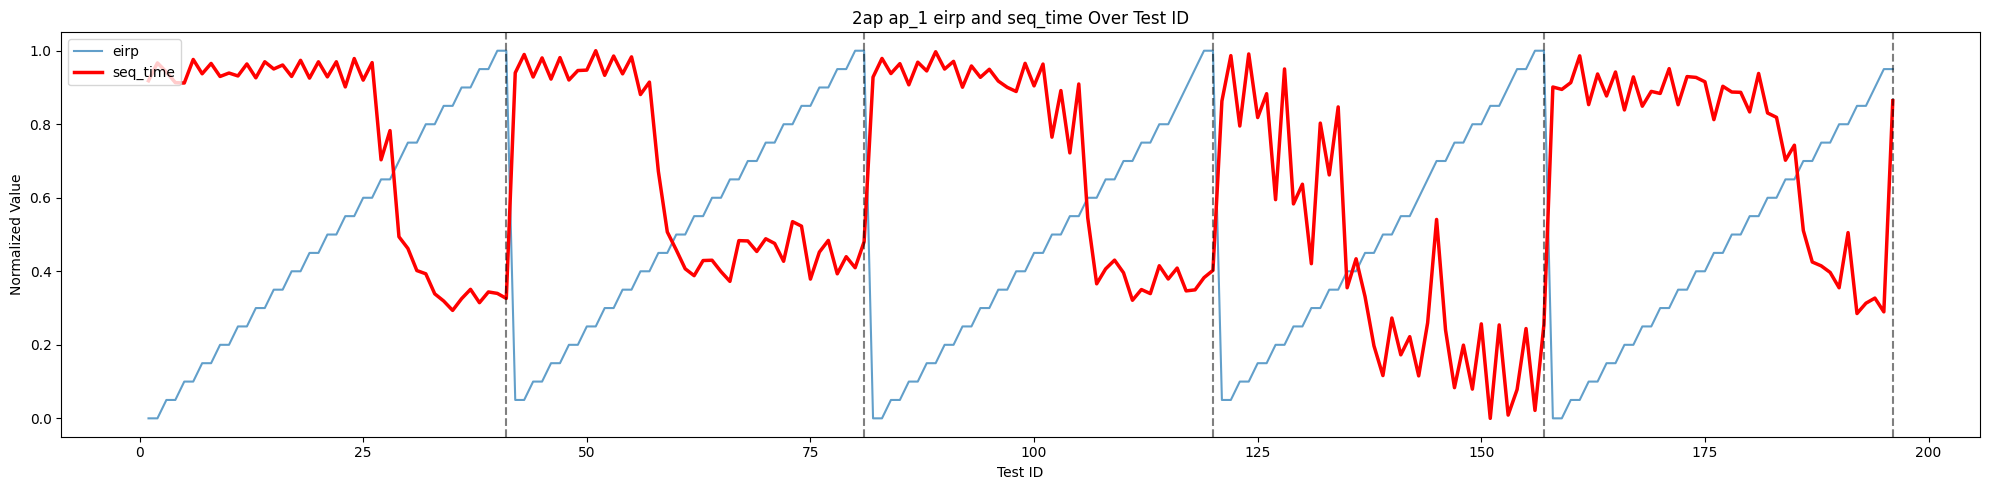

In [8]:
##### 普通指标画图 #####
columns_to_use = ["test_id", "seq_time", "test_dur", "loc_id", "bss_id", "ap_name", "ap_mac", "ap_id", "sta_mac", "sta_id", "protocol", "pkt_len", "pd", "ed", "nav", "eirp"]

for ap_name, data_ap in data_split_by_ap_name.items():
    data = data_ap.loc[:, columns_to_use].copy()
    # 编码非数值列
    label_encoder = LabelEncoder()
    for column in ["loc_id", "bss_id", "ap_name", "ap_mac", "ap_id", "sta_mac", "sta_id", "protocol"]:
        data[column] = label_encoder.fit_transform(data[column])
    # 归一化数值列
    scaler = MinMaxScaler()
    # 将需要归一化的列转换为float类型。获取要归一化的列
    columns_to_normalize = [col for col in data.columns if col != "test_id"]
    data[columns_to_normalize] = data[columns_to_normalize].astype(float)
    # 归一化
    data_scaled = data.copy()
    data_scaled.loc[:, columns_to_normalize] = scaler.fit_transform(data.loc[:, columns_to_normalize])

    # 绘制单独的图，每个数值列（以及 seq_time）一起
    for column in columns_to_use[2:]:
        plt.figure(figsize=(20, 5))
        # 绘制当前列
        plt.plot(data_scaled["test_id"], data_scaled[column], label=column, alpha=0.7)
        # 绘制 seq_time
        plt.plot(data_scaled["test_id"], data_scaled["seq_time"], label="seq_time", color="red", linewidth=2.5)
        # 绘制文件分割线
        for split in file_split_id:
            plt.axvline(x=split, color="k", linestyle="--", alpha=0.5)
        plt.title(f"{ap_count} {ap_name} {column} and seq_time Over Test ID")
        plt.xlabel("Test ID")
        plt.ylabel("Normalized Value")
        plt.legend(loc="upper left")
        plt.tight_layout()
        # 展示图像
        plt.show()

In [ ]:
###### RSSI时序数组min max mean画图 #####
# 提取指定的列，包括test_id, seq_time和数组列
columns_to_use = [
    "test_id",
    "seq_time",
    "protocol",
    "ap_from_ap_0_sum_ant_rssi",
    "ap_from_ap_0_max_ant_rssi",
    "ap_from_ap_0_mean_ant_rssi",
    "ap_from_ap_1_sum_ant_rssi",
    "ap_from_ap_1_max_ant_rssi",
    "ap_from_ap_1_mean_ant_rssi",
    "sta_to_ap_0_sum_ant_rssi",
    "sta_to_ap_0_max_ant_rssi",
    "sta_to_ap_0_mean_ant_rssi",
    "sta_to_ap_1_sum_ant_rssi",
    "sta_to_ap_1_max_ant_rssi",
    "sta_to_ap_1_mean_ant_rssi",
    "sta_from_ap_0_sum_ant_rssi",
    "sta_from_ap_0_max_ant_rssi",
    "sta_from_ap_0_mean_ant_rssi",
    "sta_from_ap_1_sum_ant_rssi",
    "sta_from_ap_1_max_ant_rssi",
    "sta_from_ap_1_mean_ant_rssi",
    "sta_from_sta_0_rssi",
    "sta_from_sta_1_rssi",
]


def process_array_column(column):
    # 把值处理为数组
    return column.apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else np.nan)


def normalize_column_by_global_min_max(column):
    # 对列中所有数组进行归一化
    # 忽略 NaN 值
    non_empty_values = column.dropna().values
    # 如果所有数据都是空的，直接返回
    if len(non_empty_values) == 0:
        return column
    # 展开所有数组，计算全局最小值和最大值
    all_values = np.concatenate(column.dropna().values)
    global_min = np.min(all_values)
    global_max = np.max(all_values)

    # print(f"Global min: {global_min}, Global max: {global_max}")
    # 使用全局 min 和 max 对每个数组进行归一化
    def normalize_array(arr):
        if isinstance(arr, np.ndarray):
            return (arr - global_min) / (global_max - global_min) if global_max != global_min else arr
        return arr

    return column.apply(normalize_array)


protocal_names = ["tcp", "udp"]
for protocal_name in protocal_names:
    for ap_name, data_ap in data_split_by_ap_name.items():
        data = data_ap.loc[:, columns_to_use].copy()
        data = data[data.loc[:, "protocol"] == protocal_name]
        data.drop("protocol", axis=1)
        statistics = {}
        for column in columns_to_use[3:]:  # 从第三列开始是数组列
            data[column] = process_array_column(data[column])  # 处理数组字符串
            # 对整个列的值进行 min-max 归一化
            data[column] = normalize_column_by_global_min_max(data[column])
            # 计算最大最小值
            statistics[f"{column}_min"] = data[column].apply(lambda x: np.min(x) if isinstance(x, np.ndarray) else np.nan)
            statistics[f"{column}_max"] = data[column].apply(lambda x: np.max(x) if isinstance(x, np.ndarray) else np.nan)
            statistics[f"{column}_mean"] = data[column].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else np.nan)

        # 将统计结果加入到DataFrame
        statistics_df = pd.DataFrame(statistics)
        data = pd.concat([data[["test_id", "seq_time"]], statistics_df], axis=1)

        # 归一化数值列
        scaler = MinMaxScaler()
        # 将需要归一化的列转换为 float 类型
        data["seq_time"] = data["seq_time"].astype(float)
        data_scaled = data.copy()
        data_scaled["seq_time"] = scaler.fit_transform(data[["seq_time"]])

        # 绘制单独的图，每个数值列（以及 seq_time）一起
        for column in columns_to_use[3:]:
            plt.figure(figsize=(16, 3))
            # 绘制当前列
            plt.plot(data_scaled["test_id"], data_scaled[f"{column}_min"], label=f"{column}_min", alpha=0.7)
            plt.plot(data_scaled["test_id"], data_scaled[f"{column}_max"], label=f"{column}_max", alpha=0.7)
            plt.plot(data_scaled["test_id"], data_scaled[f"{column}_mean"], label=f"{column}_mean", alpha=0.7)
            # 绘制 seq_time
            plt.plot(data_scaled["test_id"], data_scaled["seq_time"], label="seq_time", color="red", linewidth=2.5)
            # 绘制文件分割线
            for split in file_split_id:
                plt.axvline(x=split, color="k", linestyle="--", alpha=0.5)
            plt.title(f"{protocal_name} {ap_count} {ap_name} {column} and seq_time Over Test ID")
            plt.xlabel("Test ID")
            plt.ylabel("Normalized Value")
            plt.legend(loc="upper left")
            plt.tight_layout()
            # 展示图像
            plt.show()

In [5]:
# ###### RSSI时序数组min max mean画图 #####
# # 提取指定的列，包括test_id, seq_time和数组列
# columns_to_use = [
#     "test_id",
#     "seq_time",
#     "ap_from_ap_0_sum_ant_rssi",
#     "ap_from_ap_0_max_ant_rssi",
#     "ap_from_ap_0_mean_ant_rssi",
#     "ap_from_ap_1_sum_ant_rssi",
#     "ap_from_ap_1_max_ant_rssi",
#     "ap_from_ap_1_mean_ant_rssi",
#     "sta_to_ap_0_sum_ant_rssi",
#     "sta_to_ap_0_max_ant_rssi",
#     "sta_to_ap_0_mean_ant_rssi",
#     "sta_to_ap_1_sum_ant_rssi",
#     "sta_to_ap_1_max_ant_rssi",
#     "sta_to_ap_1_mean_ant_rssi",
#     "sta_from_ap_0_sum_ant_rssi",
#     "sta_from_ap_0_max_ant_rssi",
#     "sta_from_ap_0_mean_ant_rssi",
#     "sta_from_ap_1_sum_ant_rssi",
#     "sta_from_ap_1_max_ant_rssi",
#     "sta_from_ap_1_mean_ant_rssi",
#     "sta_from_sta_0_rssi",
#     "sta_from_sta_1_rssi",
# ]


# def process_array_column(column):
#     # 把值处理为数组
#     return column.apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else np.nan)


# def normalize_column_by_global_min_max(column):
#     # 对列中所有数组进行归一化
#     # 忽略 NaN 值
#     non_empty_values = column.dropna().values
#     # 如果所有数据都是空的，直接返回
#     if len(non_empty_values) == 0:
#         return column
#     # 展开所有数组，计算全局最小值和最大值
#     all_values = np.concatenate(column.dropna().values)
#     global_min = np.min(all_values)
#     global_max = np.max(all_values)

#     # print(f"Global min: {global_min}, Global max: {global_max}")
#     # 使用全局 min 和 max 对每个数组进行归一化
#     def normalize_array(arr):
#         if isinstance(arr, np.ndarray):
#             return (arr - global_min) / (global_max - global_min) if global_max != global_min else arr
#         return arr

#     return column.apply(normalize_array)


# for ap_name, data_ap in data_split_by_ap_name.items():
#     data = data_ap.loc[:, columns_to_use].copy()
#     statistics = {}
#     for column in columns_to_use[2:]:  # 从第三列开始是数组列
#         data[column] = process_array_column(data[column])  # 处理数组字符串
#         # 对整个列的值进行 min-max 归一化
#         data[column] = normalize_column_by_global_min_max(data[column])
#         # 计算最大最小值
#         statistics[f"{column}_min"] = data[column].apply(lambda x: np.min(x) if isinstance(x, np.ndarray) else np.nan)
#         statistics[f"{column}_max"] = data[column].apply(lambda x: np.max(x) if isinstance(x, np.ndarray) else np.nan)
#         statistics[f"{column}_mean"] = data[column].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else np.nan)

#     # 将统计结果加入到DataFrame
#     statistics_df = pd.DataFrame(statistics)
#     data = pd.concat([data[["test_id", "seq_time"]], statistics_df], axis=1)

#     # 归一化数值列
#     scaler = MinMaxScaler()
#     # 将需要归一化的列转换为 float 类型
#     data["seq_time"] = data["seq_time"].astype(float)
#     data_scaled = data.copy()
#     data_scaled["seq_time"] = scaler.fit_transform(data[["seq_time"]])

#     # 绘制单独的图，每个数值列（以及 seq_time）一起
#     for column in columns_to_use:
#         if column != "test_id" and column != "seq_time":  # test_id 作为 X 轴
#             plt.figure(figsize=(20, 5))
#             # 绘制当前列
#             plt.plot(data_scaled["test_id"], data_scaled[f"{column}_min"], label=f"{column}_min", alpha=0.7)
#             plt.plot(data_scaled["test_id"], data_scaled[f"{column}_max"], label=f"{column}_max", alpha=0.7)
#             plt.plot(data_scaled["test_id"], data_scaled[f"{column}_mean"], label=f"{column}_mean", alpha=0.7)
#             # 绘制 seq_time
#             plt.plot(data_scaled["test_id"], data_scaled["seq_time"], label="seq_time", color="red", linewidth=2.5)
#             # 绘制文件分割线
#             for split in file_split_id:
#                 plt.axvline(x=split, color="k", linestyle="--", alpha=0.5)
#             plt.title(f"{ap_num} {ap_name} {column} and seq_time Over Test ID")
#             plt.xlabel("Test ID")
#             plt.ylabel("Normalized Value")
#             plt.legend(loc="upper left")
#             plt.tight_layout()
#             # 展示图像
#             plt.show()